# Plot LAMOST DR4 and Gaia DR3 data

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import CoordTrans as ct
import agama
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats,interpolate

## Read data

In [3]:
datafile   = "../data/LMRC-DR4-VF-SNR30-newnames-GaiaeDR3.csv"
lamostgaia = pd.read_csv(datafile)

solpos = np.array([8.2,0.014,-8.6,13.9+232.8,7.1]) # McMillan 2017

# Collect coordinates (ra/rad, dec/rad, s/kpc, vr/kms-1, mura/masyr-1, 
# mudec/masyr-1, [Fe/H]/dex, [a/Fe]/dex, age/Gyr)
Obs = np.column_stack((lamostgaia["ra"]/180.*np.pi,
                       lamostgaia["dec"]/180.*np.pi,
                       lamostgaia["s"],
                       lamostgaia["vr"],
                       lamostgaia["pmra"],
                       lamostgaia["pmdec"],
                       lamostgaia["feh"],
                       lamostgaia["afe"],
                       lamostgaia["age"]))

eObs = np.column_stack((lamostgaia["ra_error"]/180.*np.pi,
                        lamostgaia["dec_error"]/180.*np.pi,
                        lamostgaia["es"],
                        lamostgaia["evr"],
                        lamostgaia["pmra_error"],
                        lamostgaia["pmdec_error"],
                        lamostgaia["efeh"],
                        lamostgaia["eafe"],
                        lamostgaia["eage"]))
print("Read LAMOST DR4 red clump supplemented with Gaia eDR3 ...")
                       
# Replace stars with NaN proper motions with original UCAC5 proper motions
index = (np.isnan(lamostgaia["pmra"])) | \
        (np.isnan(lamostgaia["pmdec"])) | \
        (np.isnan(lamostgaia["pmra_error"])) | \
        (np.isnan(lamostgaia["pmdec_error"]))
Obs[index,4]  = lamostgaia["mra"][index]
Obs[index,5]  = lamostgaia["mdec"][index]
eObs[index,4] = lamostgaia["emra"][index]
eObs[index,5] = lamostgaia["emdec"][index]
print("Replaced "+str(np.sum(index))+" stars having NaN proper motions with original UCAC5 proper motions...")

Read LAMOST DR4 red clump supplemented with Gaia eDR3 ...
Replaced 278 stars having NaN proper motions with original UCAC5 proper motions...


## Clean sample

In [4]:
# Remove stars that are likely to be massive merged stars
idx_merged_massive = (Obs[:,7]>0.12) & (Obs[:,8]<5.)
print("Removing "+str(np.sum(idx_merged_massive))+" stars that are likelly to be merged stars.")
Obs  = Obs[~idx_merged_massive,:]
eObs = eObs[~idx_merged_massive,:]

# Remove stars with ages older than the age of the Universe
idx_older_universe = Obs[:,8]>13.1
print("Removing a further "+str(np.sum(idx_older_universe))+" stars that are older than the age of the Universe.")
Obs  = Obs[~idx_older_universe,:]
eObs = eObs[~idx_older_universe,:]

Removing 5068 stars that are likelly to be merged stars.
Removing a further 2986 stars that are older than the age of the Universe.


In [5]:
# Convert to polar
we             = Obs[:,0:6]
wg             = ct.EquatorialToGalactic(we)
wp             = ct.GalacticToPolar(wg,solpos)
wc             = ct.PolarToCartesian(wp)
ObsPolarNotRef = np.column_stack((wp,Obs[:,6],Obs[:,7],Obs[:,8]))

## Plot stars in [$\alpha$/Fe]-[Fe/H] plane

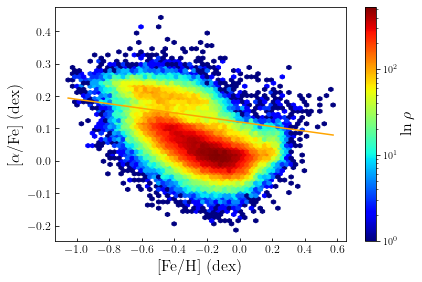

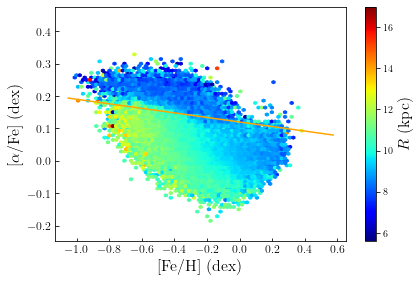

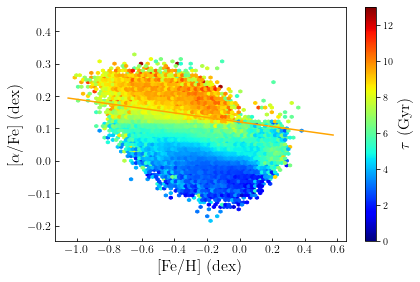

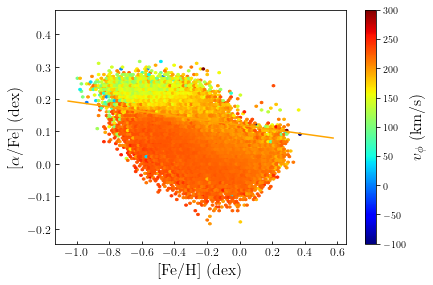

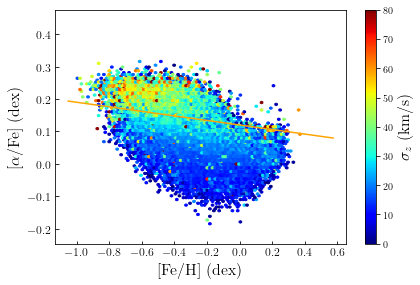

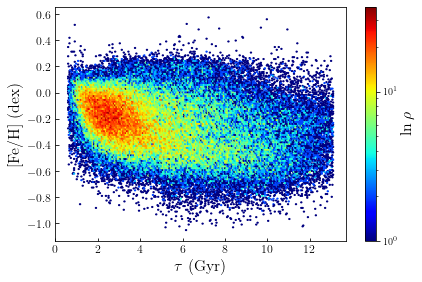

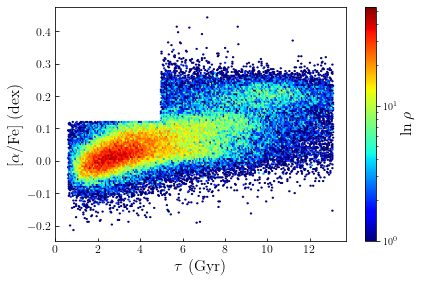

In [8]:
R    = ObsPolarNotRef[:,0]
z    = ObsPolarNotRef[:,2]
vphi = ObsPolarNotRef[:,4]
vz   = ObsPolarNotRef[:,5]
feh  = ObsPolarNotRef[:,6]
afe  = ObsPolarNotRef[:,7]
age  = ObsPolarNotRef[:,8]

fig = plt.figure(figsize=(6,4))  
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(feh,afe,bins="log",cmap="jet",gridsize=60,mincnt=1)
slope      = -0.07
yintercept = 0.12
fehgrid    = np.linspace(np.min(feh),np.max(feh),30)
afegrid    = yintercept + slope*fehgrid
plt.plot(fehgrid,afegrid,color="orange")
plt.xlabel("[Fe/H] (dex)",fontsize=16)
plt.ylabel(r"[$\alpha$/Fe] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\ln \rho$ ",size=16)
plotfile = "../plots/data/2Dhistogram_feh_afe.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_feh_afe.png"
fig.savefig(plotfile,format='png')

# 2D R map in [Fe/H]-[a/Fe]
fig = plt.figure(figsize=(6,4))   
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(feh,afe,C=R,reduce_C_function=np.mean,
                     cmap="jet",gridsize=80,mincnt=1)
plt.plot(fehgrid,afegrid,color="orange")
plt.xlabel("[Fe/H] (dex)",fontsize=16)
plt.ylabel(r"[$\alpha$/Fe] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$R$ (kpc)",size=16)
plotfile = "../plots/data/2Dhistogram_fehafe_R.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_fehafe_R.png"
fig.savefig(plotfile,format='png')

# 2D age map in [Fe/H]-[a/Fe]
fig = plt.figure(figsize=(6,4))   
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(feh,afe,C=age,reduce_C_function=np.mean,vmin=0.,vmax=13.,
                     cmap="jet",gridsize=80,mincnt=1)
plt.plot(fehgrid,afegrid,color="orange")
plt.xlabel("[Fe/H] (dex)",fontsize=16)
plt.ylabel(r"[$\alpha$/Fe] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\tau$ (Gyr)",size=16)
plotfile = "../plots/data/2Dhistogram_fehafe_age.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_fehafe_age.png"
fig.savefig(plotfile,format='png')

# 2D vphi map in [Fe/H]-[a/Fe]
fig = plt.figure(figsize=(6,4))   
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(feh,afe,C=vphi,reduce_C_function=np.mean,vmin=-100.,vmax=300.,
                     cmap="jet",gridsize=100,mincnt=1)
plt.plot(fehgrid,afegrid,color="orange")
plt.xlabel("[Fe/H] (dex)",fontsize=16)
plt.ylabel(r"[$\alpha$/Fe] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_{\phi}$ (km/s)",size=16)
plotfile = "../plots/data/2Dhistogram_fehafe_vphi.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_fehafe_vphi.png"
fig.savefig(plotfile,format='png')

# 2D sigz map in [Fe/H]-[a/Fe]
fig = plt.figure(figsize=(6,4))  
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(feh,afe,C=vz,reduce_C_function=np.std,vmin=0.,vmax=80.,
                     cmap="jet",gridsize=100,mincnt=1)
plt.plot(fehgrid,afegrid,color="orange")
plt.xlabel("[Fe/H] (dex)",fontsize=16)
plt.ylabel(r"[$\alpha$/Fe] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$ (km/s)",size=16)
plotfile = "../plots/data/2Dhistogram_fehafe_sigz.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_fehafe_sigz.png"
fig.savefig(plotfile,format='png')

# 2D density map in [Fe/H]-age
fig = plt.figure(figsize=(6,4))   
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(age,feh,bins="log",cmap="jet",gridsize=200,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\ln \rho$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_lnrho.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_lnrho.png"
fig.savefig(plotfile,format='png')

# 2D density map in [a/Fe]-age
fig = plt.figure(figsize=(6,4)) 
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
dispmap = plt.hexbin(age,afe,bins="log",cmap="jet",gridsize=200,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[$\alpha$/Fe] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\ln \rho$",size=16)
plotfile = "../plots/data/2Dhistogram_ageafe_lnrho.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_ageafe_lnrho.png"
fig.savefig(plotfile,format='png')

## Plot age-metallicity relation in age bins

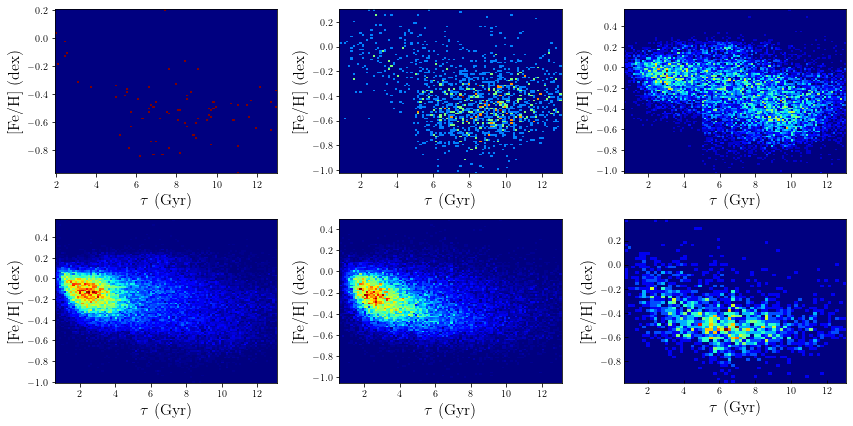

In [10]:
# 2D density map in [Fe/H]-age
fig, ax = plt.subplots(2,3,figsize=(12,6))
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")

index = (R<=4.)
ax[0,0].hist2d(age[index],feh[index],bins=[100,100],cmap="jet")
ax[0,0].set_xlabel(r"$\tau$ (Gyr)",fontsize=16)
ax[0,0].set_ylabel(r"[Fe/H] (dex)",fontsize=16)

index = ((R>4.) & (R<=6.))
ax[0,1].hist2d(age[index],feh[index],bins=[100,100],cmap="jet")
ax[0,1].set_xlabel(r"$\tau$ (Gyr)",fontsize=16)
ax[0,1].set_ylabel(r"[Fe/H] (dex)",fontsize=16)

index = ((R>6.) & (R<=8.))
ax[0,2].hist2d(age[index],feh[index],bins=[100,100],cmap="jet")
ax[0,2].set_xlabel(r"$\tau$ (Gyr)",fontsize=16)
ax[0,2].set_ylabel(r"[Fe/H] (dex)",fontsize=16)

index = ((R>8.) & (R<=10.))
ax[1,0].hist2d(age[index],feh[index],bins=[100,100],cmap="jet")
ax[1,0].set_xlabel(r"$\tau$ (Gyr)",fontsize=16)
ax[1,0].set_ylabel(r"[Fe/H] (dex)",fontsize=16)

index = ((R>10.) & (R<=12.))
ax[1,1].hist2d(age[index],feh[index],bins=[100,100],cmap="jet")
ax[1,1].set_xlabel(r"$\tau$ (Gyr)",fontsize=16)
ax[1,1].set_ylabel(r"[Fe/H] (dex)",fontsize=16)

index = (R>14.)
ax[1,2].hist2d(age[index],feh[index],bins=[60,60],cmap="jet")
ax[1,2].set_xlabel(r"$\tau$ (Gyr)",fontsize=16)
ax[1,2].set_ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.tight_layout(pad=1)
plotfile = "../plots/data/2Dhistogram_agefeh_byR.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_byR.png"
fig.savefig(plotfile,format='png')

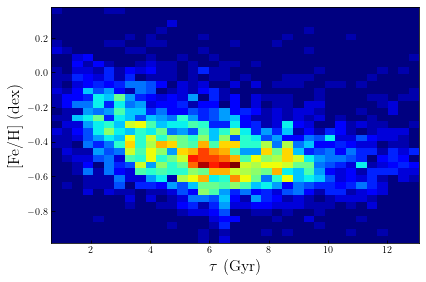

In [11]:
index = (R>13.5)
fig = plt.figure(figsize=(6,4))
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
plt.hist2d(age[index],feh[index],bins=[35,35],cmap="jet")
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.tight_layout(pad=1)
plotfile = "../plots/data/2Dhistogram_agefeh_veryouter.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_veryouter.png"
fig.savefig(plotfile,format='png')

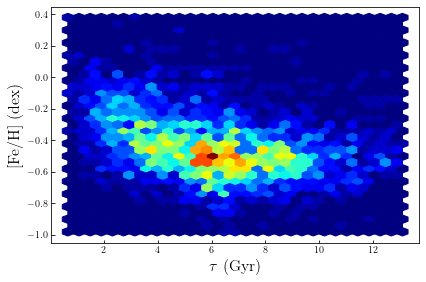

In [26]:
index = (R>13.6)
fig = plt.figure(figsize=(6,4))
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")
plt.hexbin(age[index],feh[index],gridsize=30,mincnt=0,cmap="jet")
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.tight_layout(pad=1)
plotfile = "../plots/data/2Dhistogram_agefeh_veryouter.eps"
fig.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_veryouter.png"
fig.savefig(plotfile,format='png')

## Split sample into low-alpha and high-alpha stars

In [23]:
afemax     = yintercept + slope*feh
idx_lowalpha  = afemax > afe

# Save high-alpha stars
highalphaObs            = Obs[~idx_lowalpha,:]
highalphaeObs           = eObs[~idx_lowalpha,:]
we                      = highalphaObs[:,0:6]
wg                      = ct.EquatorialToGalactic(we)
wp                      = ct.GalacticToPolar(wg,solpos)
wc                      = ct.PolarToCartesian(wp)
highalphaObsPolarNotRef = np.column_stack((wp,highalphaObs[:,6],highalphaObs[:,7],highalphaObs[:,8]))

# Save low-alpha stars
print("Removing a further "+str(len(feh) - np.sum(idx_lowalpha))+" stars that belong to the high-alpha disk.")
lowalphaObs            = Obs[idx_lowalpha,:]
lowalphaeObs           = eObs[idx_lowalpha,:]
we                     = lowalphaObs[:,0:6]
wg                     = ct.EquatorialToGalactic(we)
wp                     = ct.GalacticToPolar(wg,solpos)
wc                     = ct.PolarToCartesian(wp)
lowalphaobsPolarNotRef = np.column_stack((wp,lowalphaObs[:,6],lowalphaObs[:,7],lowalphaObs[:,8]))
len(lowalphaobsPolarNotRef)

Removing a further 14437 stars that belong to the high-alpha disk.


100998

## Calculate actions for low-alpha sample

In [45]:
# Set units for agama library
agama.setUnits(mass=1,length=1,velocity=1)

# Create potential instance
gp = agama.Potential("../data/mcmillan17.ini") 

# Create action finder instance
af  = agama.ActionFinder(gp)  

# Calculate actions
out = af(wc)
Jr = np.copy(out[:,0])
Jz = np.copy(out[:,1])
Lz = np.copy(out[:,2])

## Plot 1-D histograms of $s$, [Fe/H], [$\alpha$/Fe], and $\tau$

Minimum distance (kpc): 0.23
Maximum distance (kpc): 16.36
Minimum [Fe/H]: -1.014
Maximum [Fe/H]: 0.408
Minimum [a/Fe]: -0.213
Maximum [a/Fe]: 0.188
Minimum age: 0.6
Maximum age: 13.1
Mean [Fe/H]:-0.220813827996594
Sigma [Fe/H]:0.19210023171204263
Mean [a/Fe]:0.038756490227529264
Sigma [a/Fe]:0.05035234544155546


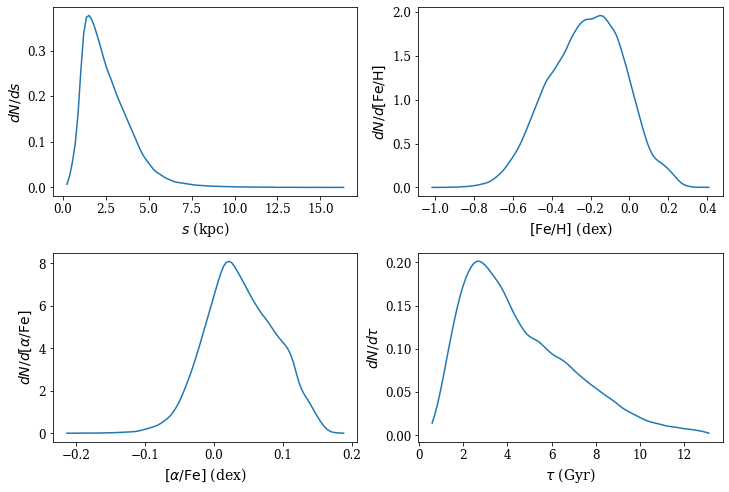

In [24]:
from scipy.stats import gaussian_kde
s   = lowalphaObs[:,2]
feh = lowalphaObs[:,6]
afe = lowalphaObs[:,7]
age = lowalphaObs[:,8]

# Print ranges for different coordinates
mins   = np.min(s)
maxs   = np.max(s)
print("Minimum distance (kpc): "+str(mins))
print("Maximum distance (kpc): "+str(maxs))
minfeh = np.min(feh)
maxfeh = np.max(feh)
print("Minimum [Fe/H]: "+str(minfeh))
print("Maximum [Fe/H]: "+str(maxfeh))
minafe = np.min(afe)
maxafe = np.max(afe)
print("Minimum [a/Fe]: "+str(minafe))
print("Maximum [a/Fe]: "+str(maxafe))
minage = np.min(age)
maxage = np.max(age)
print("Minimum age: "+str(minage))
print("Maximum age: "+str(maxage))

# 1-D histograms
plt.rc('font',family='serif')  
fig,axarr = plt.subplots(2,2,figsize=(12,8))  
fig.subplots_adjust(hspace=0.3,wspace=0.2)

# s
xs      = np.linspace(mins,maxs,100)
density = gaussian_kde(s)
axarr[0,0].plot(xs,density(xs))
axarr[0,0].set_xlabel(r"$s$ (kpc)",fontsize=14)
axarr[0,0].set_ylabel(r"$dN/ds$",fontsize=14)
axarr[0,0].tick_params(axis="both",labelsize=12)

# [Fe/H]
print("Mean [Fe/H]:"+str(np.mean(feh)))
print("Sigma [Fe/H]:"+str(np.std(feh)))
xfeh    = np.linspace(minfeh,maxfeh,100)
density = gaussian_kde(feh)
axarr[0,1].plot(xfeh,density(xfeh))
axarr[0,1].set_xlabel(r"$\mathrm{[Fe/H]}$ (dex)",fontsize=14)
axarr[0,1].set_ylabel(r"$dN/d\mathrm{[Fe/H]}$",fontsize=14)
axarr[0,1].tick_params(axis="both",labelsize=12)

# [a/Fe]
print("Mean [a/Fe]:"+str(np.mean(afe)))
print("Sigma [a/Fe]:"+str(np.std(afe)))
xafe    = np.linspace(minafe,maxafe,100)
density = gaussian_kde(afe)
axarr[1,0].plot(xafe,density(xafe))
axarr[1,0].set_xlabel(r"$[\alpha/\mathrm{Fe]}$ (dex)",fontsize=14)
axarr[1,0].set_ylabel(r"$dN/d[\alpha/\mathrm{Fe]}$",fontsize=14)
axarr[1,0].tick_params(axis="both",labelsize=12)

# Age
xage    = np.linspace(minage,maxage,100)
density = gaussian_kde(age)
axarr[1,1].plot(xage,density(xage))
axarr[1,1].set_xlabel(r"$\tau$ (Gyr)",fontsize=14)
axarr[1,1].set_ylabel(r"$dN/d\tau$",fontsize=14)
axarr[1,1].tick_params(axis="both",labelsize=12)

# Save to file
plotfile = "../plots/data/1Dhistograms_lowalpha.eps"
fig.savefig(plotfile,format='eps',bbox_inches='tight', pad_inches=0)

## Plot 1D histograms in the outer disc

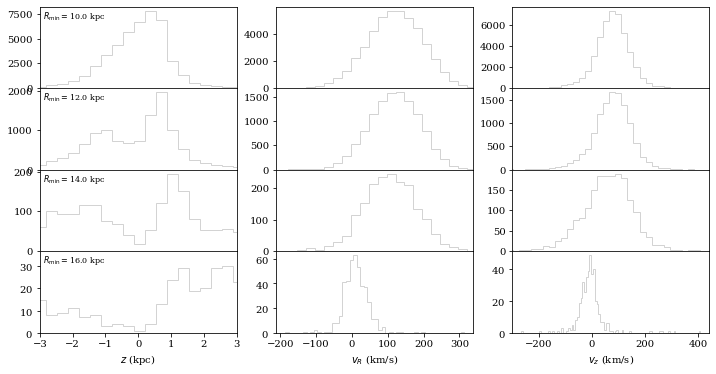

In [32]:
# Examine distributions over different radial ranges
R    = lowalphaobsPolarNotRef[:,0]
z    = lowalphaobsPolarNotRef[:,2]
vR   = lowalphaobsPolarNotRef[:,3]
vphi = lowalphaobsPolarNotRef[:,4]
vz   = lowalphaobsPolarNotRef[:,5]
feh  = lowalphaobsPolarNotRef[:,6]
afe  = lowalphaobsPolarNotRef[:,7]
age  = lowalphaobsPolarNotRef[:,8]
Rmin  = np.array([10.,12.,14.,16.])
nR    = len(Rmin)

fig,axarr  = plt.subplots(nR,3,figsize=(12,6))

index = R>Rmin[nR-1]
label = r"$R_{\mathrm{min}}=$"+str(Rmin[nR-1])+" kpc"
n,binsz,patches=axarr[nR-1,0].hist(z[index],bins=50,
                               histtype="step",color="lightgray",label=label)
axarr[nR-1,0].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,0].set_xlabel(r"$z$ (kpc)")
axarr[nR-1,0].set_xlim([-3.,3.])
axarr[nR-1,0].text(-2.9, 0.9*np.max(n), label,fontsize=8)
    
n,binsvR,patches=axarr[nR-1,1].hist(vR[index],bins=50,
                                    histtype="step",color="lightgray")
axarr[nR-1,1].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,1].set_xlabel(r"$v_R$ (km/s)")
#axarr[nR-1,1].set_xlim([-110.,110.])

n,binsvz,patches=axarr[nR-1,2].hist(vz[index],bins=100,
                                    histtype="step",color="lightgray")
#axarr[nR-1,2].set_xlim([-110.,110.])
axarr[nR-1,2].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,2].set_xlabel(r"$v_z$ (km/s)")

for jR in range(nR-1):
    index = R>Rmin[jR]
    label = r"$R_{\mathrm{min}}=$"+str(Rmin[jR])+" kpc"
    n,binsz,patches = axarr[jR,0].hist(z[index],bins=binsz,histtype="step",color="lightgray",label=label)
    axarr[jR,0].get_xaxis().set_visible(False)
    axarr[jR,0].set_xlim([-3.,3.])
    axarr[jR,0].text(-2.9, 0.9*np.max(n), label,fontsize=8)
  
    axarr[jR,1].hist(vR[index],bins=binsvR,histtype="step",color="lightgray")
    axarr[jR,1].get_xaxis().set_visible(False)
    axarr[jR,1].set_xlim([-110.,110.])

    axarr[jR,2].hist(vz[index],bins=binsvz,histtype="step",color="lightgray")
    axarr[jR,2].get_xaxis().set_visible(False)
    axarr[jR,2].set_xlim([-110.,110.])

fig.subplots_adjust(hspace=0.0,wspace=0.2)

plotfile = "../plots/data/1DDistributions_phasespace_lowalpha.eps"
fig.savefig(plotfile,format='eps')

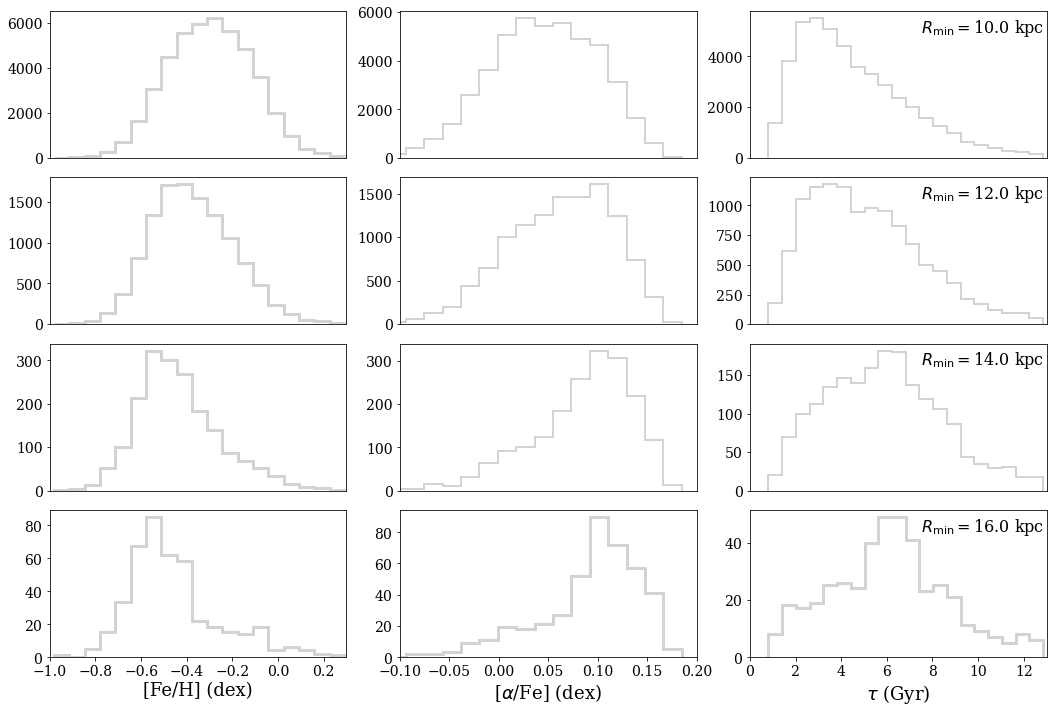

In [30]:
# Examine distributions over different radial ranges
R    = lowalphaobsPolarNotRef[:,0]
z    = lowalphaobsPolarNotRef[:,2]
vR   = lowalphaobsPolarNotRef[:,3]
vphi = lowalphaobsPolarNotRef[:,4]
vz   = lowalphaobsPolarNotRef[:,5]
feh  = lowalphaobsPolarNotRef[:,6]
afe  = lowalphaobsPolarNotRef[:,7]
age  = lowalphaobsPolarNotRef[:,8]
Rmin  = np.array([10.,12.,14.,16.])
nR    = len(Rmin)

fig,axarr  = plt.subplots(nR,3,figsize=(15,10))

index = R>Rmin[nR-1]
label = r"$R_{\mathrm{min}}=$"+str(Rmin[nR-1])+" kpc"
n,binsfeh,patches=axarr[nR-1,0].hist(lowalphaobsPolarNotRef[index,6],bins=20,
                               histtype="stepfilled",linewidth=3,color="lightgray",label=label)
axarr[nR-1,0].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,0].set_xlabel(r"[Fe/H] (dex)",fontsize=18)
axarr[nR-1,0].set_xlim([-1.0,0.3])
axarr[nR-1,0].tick_params(axis='x', labelsize=14)
axarr[nR-1,0].tick_params(axis='y', labelsize=14)
    
n,binsafe,patches=axarr[nR-1,1].hist(lowalphaobsPolarNotRef[index,7],bins=20,
                                     histtype="stepfilled",linewidth=3,color="lightgray")
axarr[nR-1,1].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,1].set_xlabel(r"[$\alpha$/Fe] (dex)",fontsize=18)
axarr[nR-1,1].set_xlim([-0.1,0.2])
axarr[nR-1,1].tick_params(axis='x', labelsize=14)
axarr[nR-1,1].tick_params(axis='y', labelsize=14)

n,binsage,patches=axarr[nR-1,2].hist(lowalphaobsPolarNotRef[index,8],bins=20,
                                     histtype="stepfilled",linewidth=3,color="lightgray")
axarr[nR-1,2].set_xlim([0.,13.])
axarr[nR-1,2].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,2].set_xlabel(r"$\tau$ (Gyr)",fontsize=18)
axarr[nR-1,2].tick_params(axis='x', labelsize=14)
axarr[nR-1,2].tick_params(axis='y', labelsize=14)
axarr[nR-1,2].text(7.5, 0.9*np.max(n), label,fontsize=16)

for jR in range(nR-1):
    index = R>Rmin[jR]
    label = r"$R_{\mathrm{min}}=$"+str(Rmin[jR])+" kpc"
    axarr[jR,0].hist(lowalphaobsPolarNotRef[index,6],bins=binsfeh,
                     histtype="stepfilled",linewidth=3,color="lightgray",label=label)
    axarr[jR,0].get_xaxis().set_visible(False)
    axarr[jR,0].set_xlim([-1.0,0.3])
    axarr[jR,0].tick_params(axis='y',labelsize=14)
  
    axarr[jR,1].hist(lowalphaobsPolarNotRef[index,7],bins=binsafe,
                     histtype="stepfilled",linewidth=2,color="lightgray")
    axarr[jR,1].get_xaxis().set_visible(False)
    axarr[jR,1].set_xlim([-0.1,0.2])
    axarr[jR,1].tick_params(axis='y',labelsize=14)

    n,binsage,patches=axarr[jR,2].hist(lowalphaobsPolarNotRef[index,8],bins=binsage,
                                       histtype="stepfilled",linewidth=2,color="lightgray")
    axarr[jR,2].get_xaxis().set_visible(False)
    axarr[jR,2].set_xlim([0.,13.])
    axarr[jR,2].text(7.5, 0.9*np.max(n),label,fontsize=16)
    axarr[jR,2].tick_params(axis='y',labelsize=14)

fig.subplots_adjust(hspace=0.0,wspace=0.2)
fig.tight_layout()

plotfile = "../plots/data/1DDistributions_chemistryage_lowalpha.eps"
fig.savefig(plotfile,format='eps')

plotfile = "../plots/data/1DDistributions_chemistryage_lowalpha.png"
fig.savefig(plotfile,format='png')

In [ ]:
# Fit two-component GMM to fe/h, afe, and age
from sklearn.mixture import GaussianMixture

gm  = GaussianMixture(n_components=2, random_state=0).fit(obsPolarNotRef[index,6:])
print(gm.weights_)
print(" ")
print(gm.means_)
print(" ")
print(gm.covariances_)

In [ ]:
# Generate samples from model
gmmSamples = gm.sample(10000)

In [ ]:
# Examine distributions over different radial ranges
Rmin  = np.array([10.,12.,14.,16.])
nR    = len(Rmin)

fig,axarr  = plt.subplots(nR,3,figsize=(12,8))
plt.rcParams['text.usetex'] = True
plt.tick_params(direction="in")

index = obsPolarNotRef[:,0]>Rmin[nR-1]
label = r"$R_{\mathrm{min}}=$"+str(Rmin[nR-1])+" kpc"
n,binsfeh,patches=axarr[nR-1,0].hist(obsPolarNotRef[index,6],bins=20,density=True,histtype="stepfilled",color="lightgray",label=label)
axarr[nR-1,0].hist(gmmSamples[0][:,0],bins=binsfeh,density=True,histtype="step",linewidth=2,color="steelblue",label=label)
axarr[nR-1,0].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,0].set_xlabel(r"[Fe/H] (dex)",fontsize=18)
axarr[nR-1,0].set_xlim([-1.0,0.3])
axarr[nR-1,0].tick_params(axis='x', labelsize=14)
axarr[nR-1,0].tick_params(axis='y', labelsize=14)
    
n,binsafe,patches=axarr[nR-1,1].hist(obsPolarNotRef[index,7],bins=20,density=True,histtype="stepfilled",color="lightgray")
axarr[nR-1,1].hist(gmmSamples[0][:,1],bins=binsafe,density=True,histtype="step",linewidth=2,color="steelblue",label=label)
axarr[nR-1,1].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,1].set_xlabel(r"[$\alpha$/Fe] (dex)",fontsize=18)
axarr[nR-1,1].set_xlim([-0.1,0.2])
axarr[nR-1,1].tick_params(axis='x', labelsize=14)
axarr[nR-1,1].tick_params(axis='y', labelsize=14)

n,binsage,patches=axarr[nR-1,2].hist(obsPolarNotRef[index,8],bins=20,density=True,histtype="stepfilled",color="lightgray")
axarr[nR-1,2].hist(gmmSamples[0][:,2],bins=binsage,density=True,histtype="step",linewidth=2,color="steelblue",label=label)
axarr[nR-1,2].set_xlim([0.,13.])
axarr[nR-1,2].ticklabel_format(axis='y', style='sci',scilimits=[0,2],useMathText="True")
axarr[nR-1,2].set_xlabel(r"$\tau$ (Gyr)",fontsize=18)
axarr[nR-1,2].tick_params(axis='x', labelsize=14)
axarr[nR-1,2].tick_params(axis='y', labelsize=14)
axarr[nR-1,2].text(7.5, 0.9*np.max(n), label,fontsize=16)

for jR in range(nR-1):
    index = obsPolarNotRef[:,0]>Rmin[jR]
    label = r"$R_{\mathrm{min}}=$"+str(Rmin[jR])+" kpc"
    axarr[jR,0].hist(obsPolarNotRef[index,6],bins=binsfeh,density=True,histtype="stepfilled",color="lightgray",label=label)
    axarr[jR,0].get_xaxis().set_visible(False)
    axarr[jR,0].set_xlim([-1.0,0.3])
    axarr[jR,0].tick_params(axis='y',labelsize=14)
  
    axarr[jR,1].hist(obsPolarNotRef[index,7],bins=binsafe,density=True,histtype="stepfilled",color="lightgray")
    axarr[jR,1].get_xaxis().set_visible(False)
    axarr[jR,1].set_xlim([-0.1,0.2])
    axarr[jR,1].tick_params(axis='y',labelsize=14)

    n,binsage,patches=axarr[jR,2].hist(obsPolarNotRef[index,8],bins=binsage,density=True,histtype="stepfilled",color="lightgray")
    axarr[jR,2].get_xaxis().set_visible(False)
    axarr[jR,2].set_xlim([0.,13.])
    axarr[jR,2].text(6.5, 0.85*np.max(n),label,fontsize=16)
    axarr[jR,2].tick_params(axis='y',labelsize=14)

fig.subplots_adjust(hspace=0.0,wspace=0.2)
fig.tight_layout()

plotfile = PLOTSDIR+"1DDistributions_chemistryage_lowalpha_gmm.eps"
fig.savefig(plotfile,format='eps')

## Plot 2-D $R$-$z$ maps

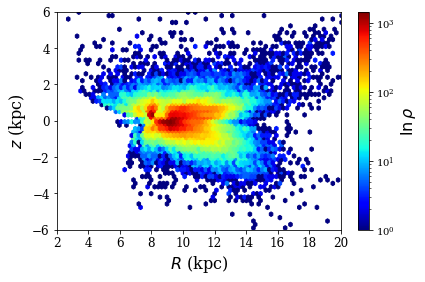

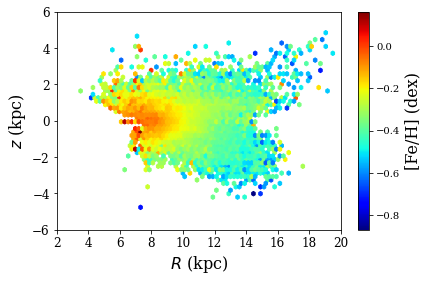

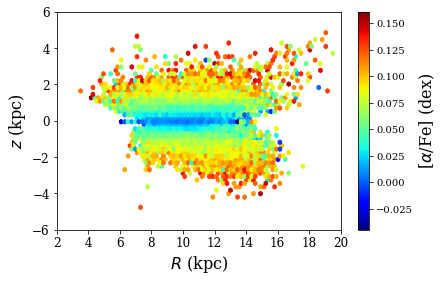

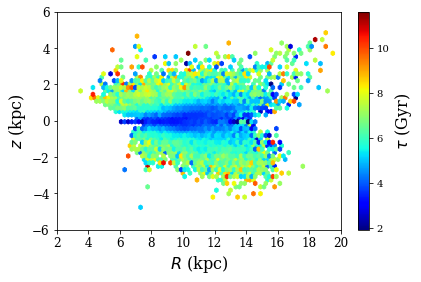

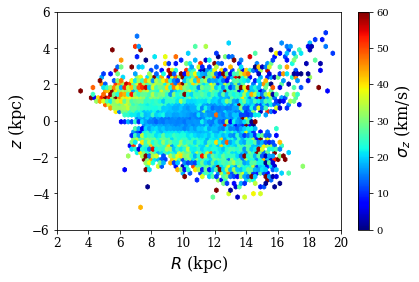

In [33]:
# 2D density map in R-z
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
densitymap = plt.hexbin(R,z,bins="log",cmap="jet",gridsize=100,mincnt=1)
plt.xlim([2.,20.])
plt.ylim([-6.,6.])
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$z$ (kpc)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(densitymap).set_label(label=r"$\ln \rho$",size=16)
plotfile = "../plots/data/2Dhistogram_Rz_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rz_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D feh map in R-z
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
agemap = plt.hexbin(R,z,C=feh,cmap="jet",gridsize=100,mincnt=1)
plt.xlim([2.,20.])
plt.ylim([-6.,6.])
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$z$ (kpc)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(agemap).set_label(label="[Fe/H] (dex)",size=16)
plotfile = "../plots/data/2Dhistogram_Rz_feh_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rz_feh_lowalpha.png"
fig4.savefig(plotfile,format='png')

# 2D afe map in R-z
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
agemap = plt.hexbin(R,z,C=afe,cmap="jet",gridsize=100,mincnt=1)
plt.xlim([2.,20.])
plt.ylim([-6.,6.])
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$z$ (kpc)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(agemap).set_label(label=r"[$\alpha$/Fe] (dex)",size=16)
plotfile = "../plots/data/2Dhistogram_Rz_afe_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rz_afe_lowalpha.png"
fig4.savefig(plotfile,format='png')

# 2D age map in R-z
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
agemap = plt.hexbin(R,z,C=age,cmap="jet",gridsize=100,mincnt=1)
plt.xlim([2.,20.])
plt.ylim([-6.,6.])
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$z$ (kpc)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(agemap).set_label(label=r"$\tau$ (Gyr)",size=16)
plotfile = "../plots/data/2Dhistogram_Rz_age_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rz_age_lowalpha.png"
fig4.savefig(plotfile,format='png')

# 2D sigma_z map in R-z
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R,z,C=vz,reduce_C_function=np.std,vmin=0.,vmax=60.,
                     cmap="jet",gridsize=100,mincnt=1)
plt.xlim([2.,20.])
plt.ylim([-6.,6.])
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$z$ (kpc)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$ (km/s)",size=16)
plotfile = "../plots/data/2Dhistogram_Rz_sigz_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rz_sigz_lowalpha.png"
fig4.savefig(plotfile,format='png')

## Plot 2-D $\tau$-[Fe/H] maps

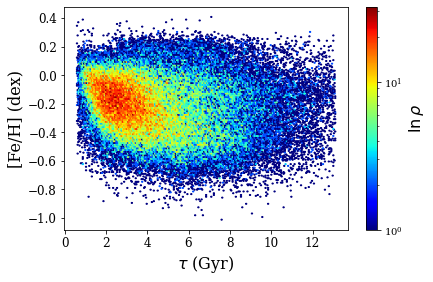

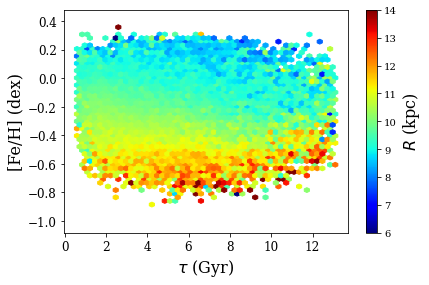

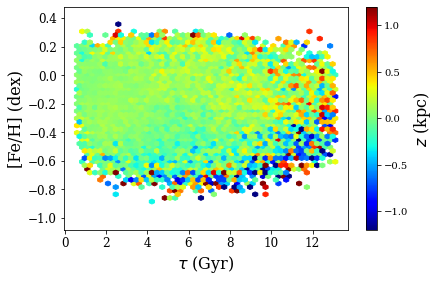

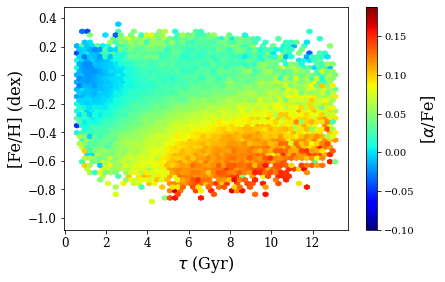

In [34]:
R    = lowalphaobsPolarNotRef[:,0]
z    = lowalphaobsPolarNotRef[:,2]
vR   = lowalphaobsPolarNotRef[:,3]
vphi = lowalphaobsPolarNotRef[:,4]
vz   = lowalphaobsPolarNotRef[:,5]
feh  = lowalphaobsPolarNotRef[:,6]
afe  = lowalphaobsPolarNotRef[:,7]
age  = lowalphaobsPolarNotRef[:,8]

# 2D density map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,bins="log",cmap="jet",gridsize=200,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\ln \rho$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_lnrho_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_lnrho_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D R map in [Fe/H]-age
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=R,reduce_C_function=np.mean,vmin=6.,vmax=14.,
                     cmap="jet",gridsize=50,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$R$ (kpc)",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_R_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_R_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D z map in [Fe/H]-age
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=z,reduce_C_function=np.mean,vmin=-1.2,vmax=1.2,
                     cmap="jet",gridsize=50,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$z$ (kpc)",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_z_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_z_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D [a/Fe] map in [Fe/H]-age
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=afe,reduce_C_function=np.mean,vmin=-0.1,vmax=np.max(afe),
                     cmap="jet",gridsize=50,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel("[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"[$\alpha$/Fe]",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_afe_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_afe_lowalpha.png"
fig3.savefig(plotfile,format='png')

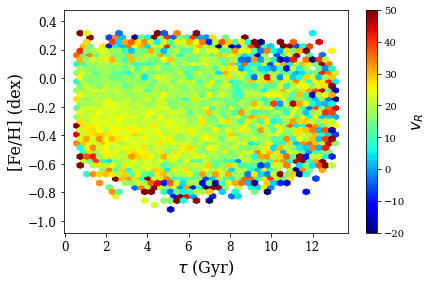

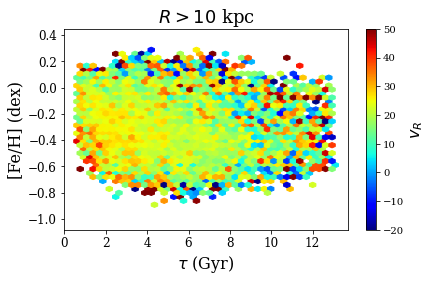

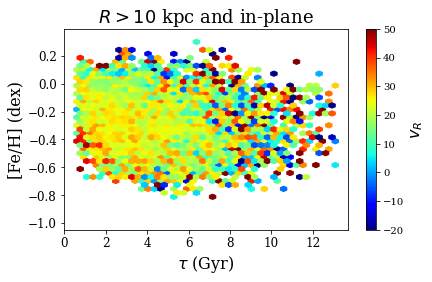

In [35]:
VMIN = -20.
VMAX = 50.

# 2D vR map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=vR,
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_R$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vR_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vR_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D vR map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vR[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_R$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vR_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vR_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D vR map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vR[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_R$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vR_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vR_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

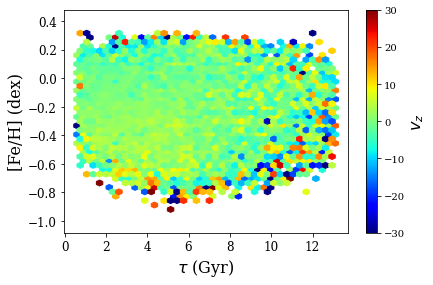

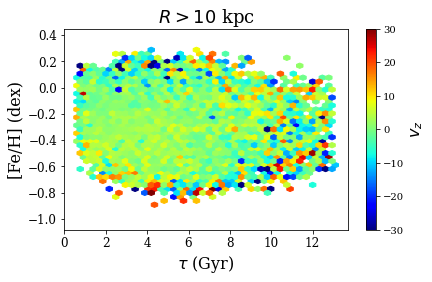

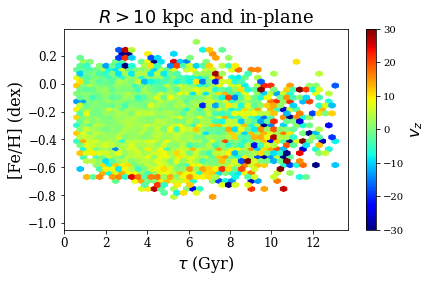

In [36]:
VMIN = -30.
VMAX = 30.

# 2D vz map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=vz,
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vz_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vz_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D vz map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vz[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vz_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vz_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D vz map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vz[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vz_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vz_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

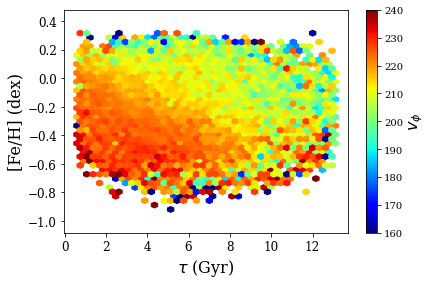

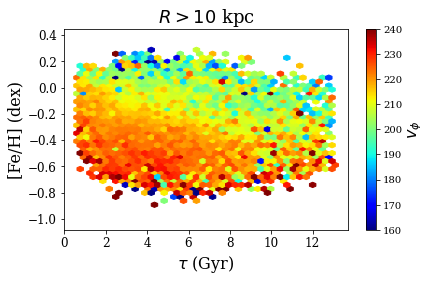

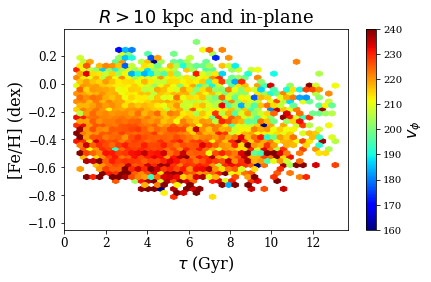

In [37]:
VMIN = 160.
VMAX = 240.

# 2D vphi map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=vphi,
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_{\phi}$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vphi_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vphi_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D vphi map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vphi[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_{\phi}$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vphi_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vphi_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D vphi map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vphi[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$v_{\phi}$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_vphi_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_vphi_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

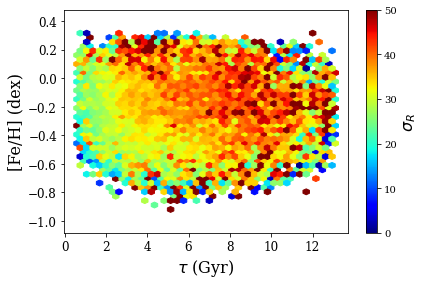

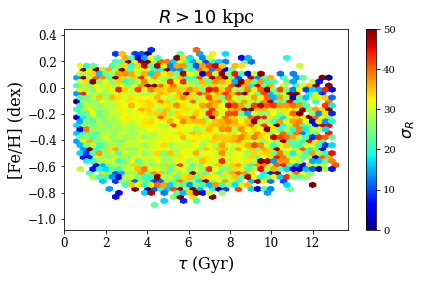

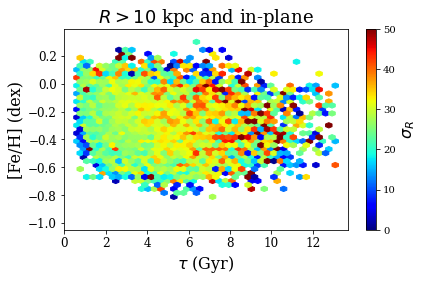

In [38]:
VMIN = 0.
VMAX = 50.

# 2D sigmaR map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=vR,
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_R$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaR_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaR_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D sigmaR map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vR[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_R$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaR_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaR_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D sigmaR map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vR[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_R$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaR_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaR_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

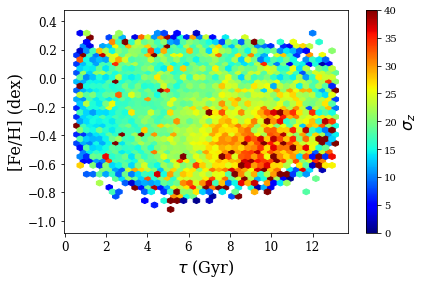

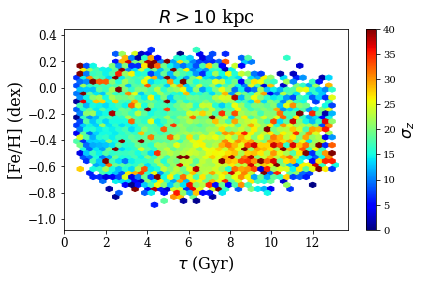

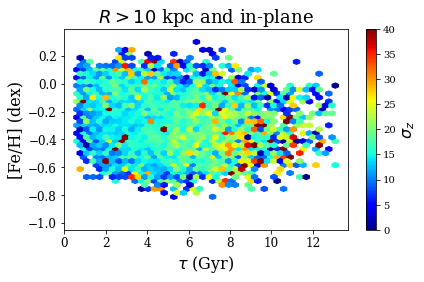

In [39]:
VMIN = 0.
VMAX = 40.

# 2D sigmaz map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=vz,
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaz_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaz_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D sigmaz map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vz[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaz_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaz_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D sigmaz map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vz[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaz_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaz_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

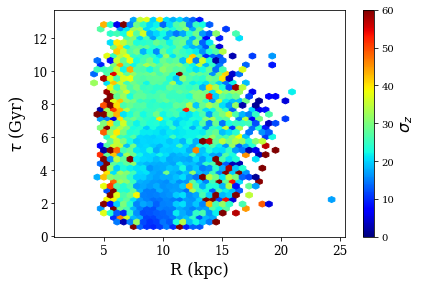

In [40]:
VMIN = 0.
VMAX = 60.

# 2D sigmaz map in age-R
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R,age,C=vz,
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"R (kpc)",fontsize=16)
plt.ylabel(r"$\tau$ (Gyr)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$",size=16)
plotfile = "../plots/data/2Dhistogram_Rage_sigmaz_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rage_sigmaz_lowalpha.png"
fig1.savefig(plotfile,format='png')

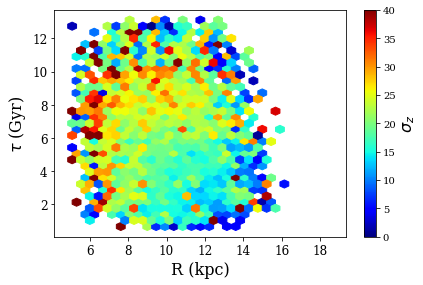

In [42]:
# 2D sigmaz map in age-R in outer disc above and below plane
index = (np.abs(z)>0.6) & (np.abs(z)<1.0)
VMAX = 40.
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R[index],age[index],C=vz[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=30,mincnt=1)
#plt.xlim([10.,14.])
plt.xlabel(r"R (kpc)",fontsize=16)
plt.ylabel(r"$\tau$ (Gyr)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$",size=16)
plotfile = "../plots/data/2Dhistogram_Rage_sigmaz_Rmin10_beyondplane_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rage_sigmaz_Rmin10_beyondplane_lowalpha.png"
fig1.savefig(plotfile,format='png')

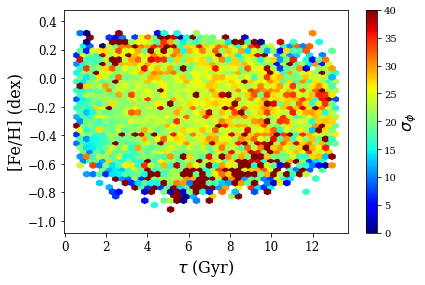

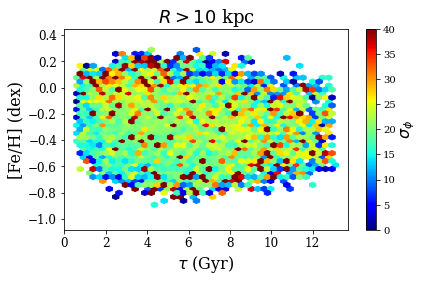

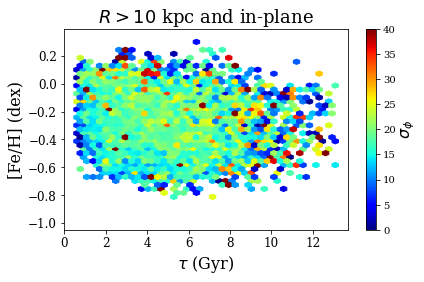

In [43]:
# 2D sigmaphi map in [Fe/H]-age

VMIN = 0.
VMAX = 40.

# 2D sigmaphi map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=vphi,
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_{\phi}$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaphi_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaphi_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D sigmaphi map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vphi[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_{\phi}$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaphi_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaphi_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D sigmaphi map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=vphi[index],
                     reduce_C_function=np.std,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_{\phi}$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaphi_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_sigmaphi_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

/tmp/ipykernel_6977/3810522088.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  dispmap = plt.hexbin(age,feh,C=Jr,
/tmp/ipykernel_6977/3810522088.py:25: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  dispmap = plt.hexbin(age[index],feh[index],C=Jr[index],
/tmp/ipykernel_6977/3810522088.py:44: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  dispmap = plt.hexbin(age[index],feh[index],C=Jr[index],
/tmp/ipykernel_6977/3810522088.py:63: MatplotlibDeprecationWarning: Passing p

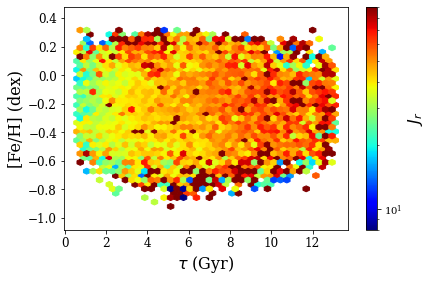

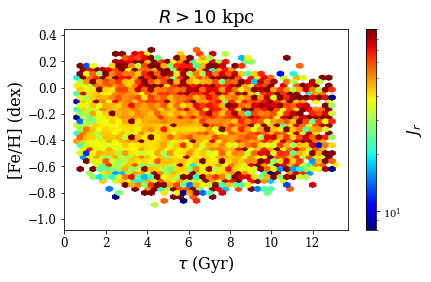

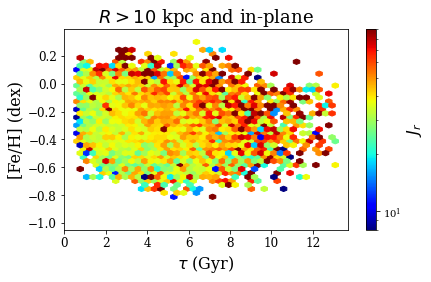

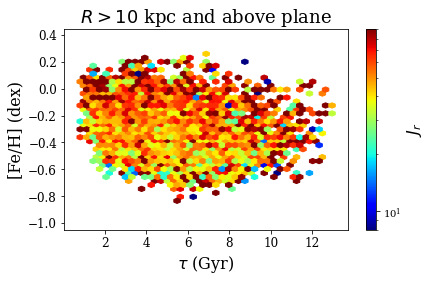

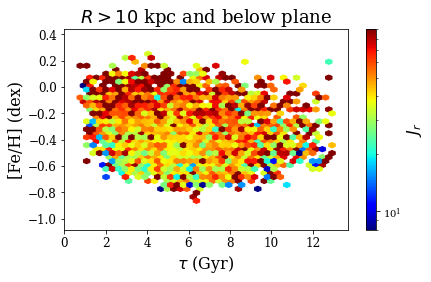

In [46]:
VMIN = 8.
VMAX = 90.

# 2D Jr map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=Jr,
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_r$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D Jr map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jr[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_r$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D Jr map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jr[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_r$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

# 2D Jr map in [Fe/H]-age for outer disc above plane
index = (R>10) & (z>0.6)
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jr[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and above plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_r$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_aboveplane_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_aboveplane_lowalpha.png"
fig4.savefig(plotfile,format='png')

# 2D Jr map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<-0.6)
plt.rc('font',family='serif')  
fig5 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jr[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and below plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_r$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_belowplane_lowalpha.eps"
fig5.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jr_Rmin10_belowplane_lowalpha.png"
fig5.savefig(plotfile,format='png')

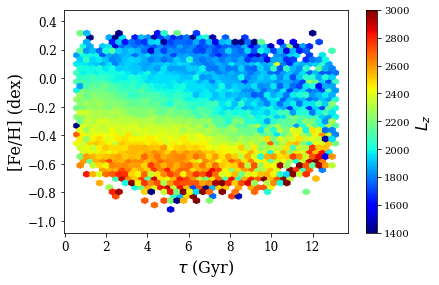

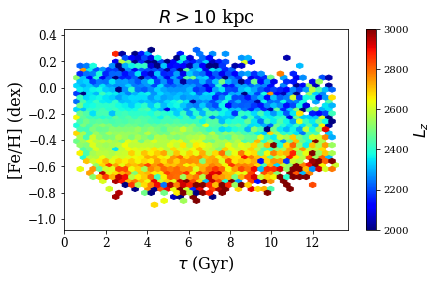

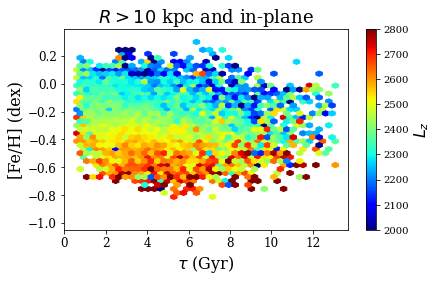

In [47]:
VMIN = 1200
VMAX = 3000.

# 2D Lz map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=Lz,
                     reduce_C_function=np.mean,cmap="jet",vmin=1400,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$L_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Lz_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Lz_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D Jr map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Lz[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=2000,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$L_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Lz_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Lz_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D Jr map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Lz[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=2000,vmax=2800,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$L_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Lz_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Lz_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

/tmp/ipykernel_6977/3422960635.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  dispmap = plt.hexbin(age,feh,C=Jz,
/tmp/ipykernel_6977/3422960635.py:25: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  dispmap = plt.hexbin(age[index],feh[index],C=Jz[index],
/tmp/ipykernel_6977/3422960635.py:44: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  dispmap = plt.hexbin(age[index],feh[index],C=Jz[index],
/tmp/ipykernel_6977/3422960635.py:63: MatplotlibDeprecationWarning: Passing p

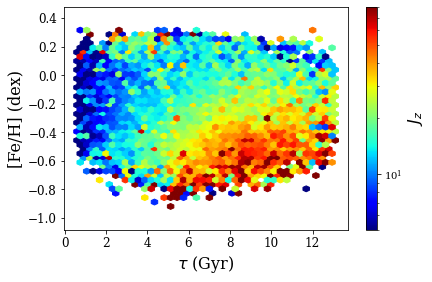

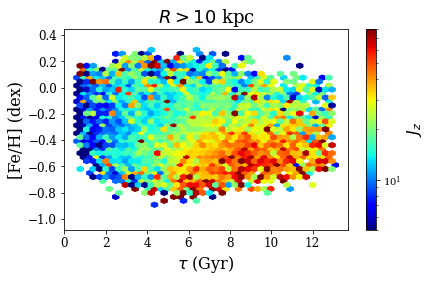

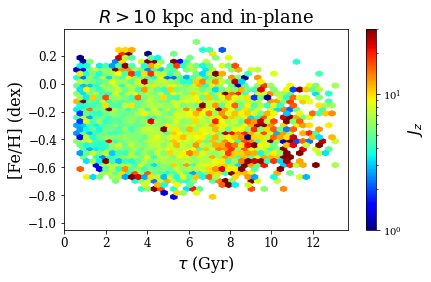

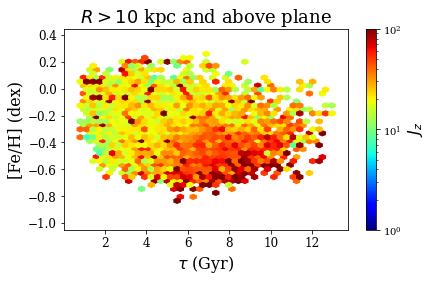

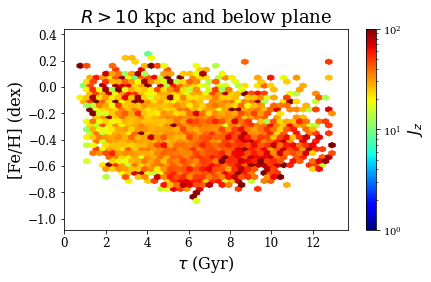

In [48]:
VMIN = 5.
VMAX = 80.

# 2D Jz map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=Jz,
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D Jz map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jz[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=VMIN,vmax=VMAX,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D Jz map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jz[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=1,vmax=30,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

# 2D Jz map in [Fe/H]-age for outer disc above plane
index = (R>10) & (z>0.6)
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jz[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=1,vmax=100,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and above plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_aboveplane_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_aboveplane_lowalpha.png"
fig4.savefig(plotfile,format='png')

# 2D Jz map in [Fe/H]-age for outer disc below plane
index = (R>10) & (z<-0.6)
plt.rc('font',family='serif')  
fig5 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=Jz[index],
                     reduce_C_function=np.mean,cmap="jet",bins="log",vmin=1,vmax=100,
                     gridsize=40,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and below plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$J_z$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_belowplane_lowalpha.eps"
fig5.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_Jz_Rmin10_belowplane_lowalpha.png"
fig5.savefig(plotfile,format='png')

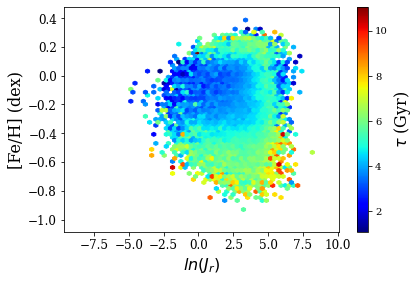

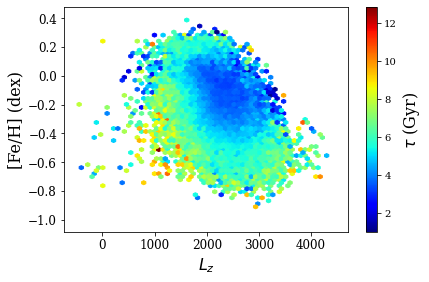

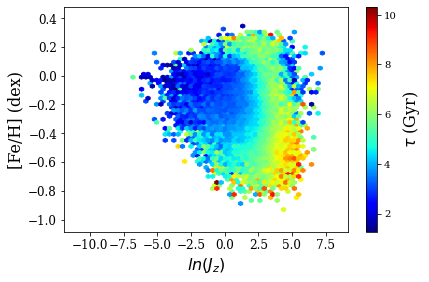

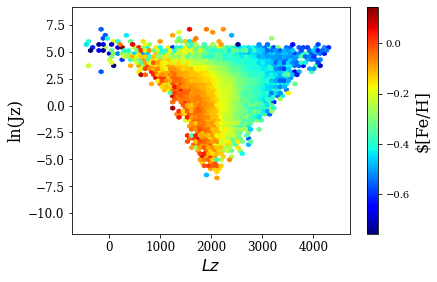

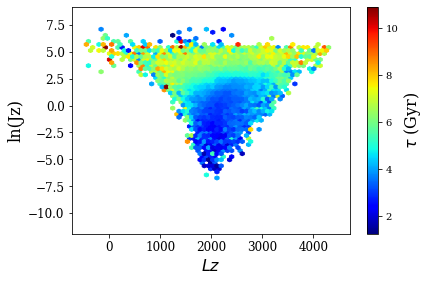

In [68]:
index = (Lz< 4500.) & (Lz>-500.)
# 2D age map in Jr-[Fe/H]
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(np.log(Jr[index]),feh[index],C=age[index],reduce_C_function=np.mean,cmap="jet",gridsize=60,mincnt=1)
plt.xlabel(r"$ln(J_r)$",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\tau$ (Gyr)",size=16)
plotfile = "../plots/data/2Dhistogram_Jrfeh_age_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Jrfeh_age_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D age map in Lz-[Fe/H]
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(Lz[index],feh[index],C=age[index],reduce_C_function=np.mean,cmap="jet",gridsize=60,mincnt=1)
plt.xlabel(r"$L_z$",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\tau$ (Gyr)",size=16)
plotfile = "../plots/data/2Dhistogram_Lzfeh_age_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Lzfeh_age_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D age map in Jz-[Fe/H]
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(np.log(Jz[index]),feh[index],C=age[index],reduce_C_function=np.mean,cmap="jet",gridsize=60,mincnt=1)
plt.xlabel(r"$ln(J_z)$",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\tau$ (Gyr)",size=16)
plotfile = "../plots/data/2Dhistogram_Jzfeh_age_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Jzfeh_age_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D feh map in Lz-Jz
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(Lz[index],np.log(Jz[index]),C=feh[index],reduce_C_function=np.mean,cmap="jet",gridsize=60,mincnt=1)
plt.xlabel(r"$Lz$",fontsize=16)
plt.ylabel(r"ln(Jz)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$[Fe/H]",size=16)
plotfile = "../plots/data/2Dhistogram_LzJz_feh_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_LzJz_feh_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D age map in Lz-Jz
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(Lz[index],np.log(Jz[index]),C=age[index],reduce_C_function=np.mean,cmap="jet",gridsize=60,mincnt=1)
plt.xlabel(r"$Lz$",fontsize=16)
plt.ylabel(r"ln(Jz)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\tau$ (Gyr)",size=16)
plotfile = "../plots/data/2Dhistogram_LzJz_age_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_LzJz_age_lowalpha.png"
fig1.savefig(plotfile,format='png')

(array([ 535., 2862., 4214., 3859., 3129., 2373., 1720.,  977.,  358.,
          61.]),
 array([0.187 , 0.4156, 0.6442, 0.8728, 1.1014, 1.33  , 1.5586, 1.7872,
        2.0158, 2.2444, 2.473 ]),
 <BarContainer object of 10 artists>)

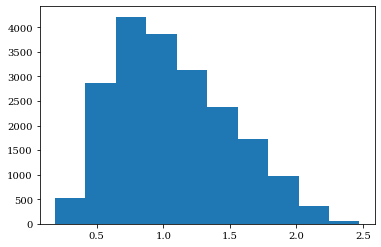

In [25]:
# Look at age uncertainties for young stars in the outer disc beyond 10 kpc
index = (R>10) & (z<0.6) & (z>-0.6) & (age<6.)
eAge  = lowalphaeObs[:,8]
plt.hist(eAge[index])

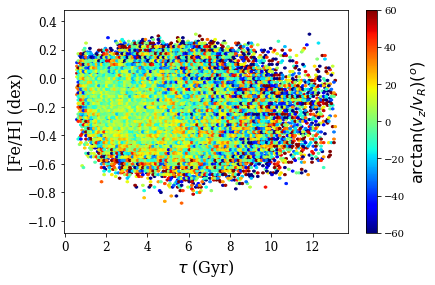

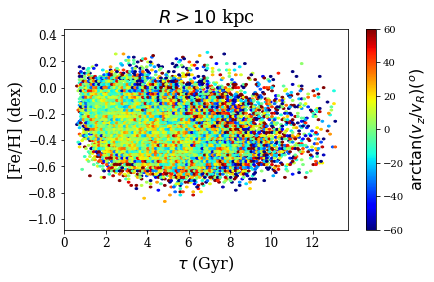

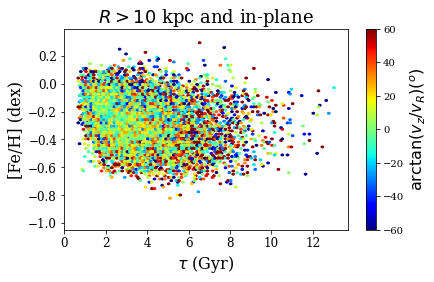

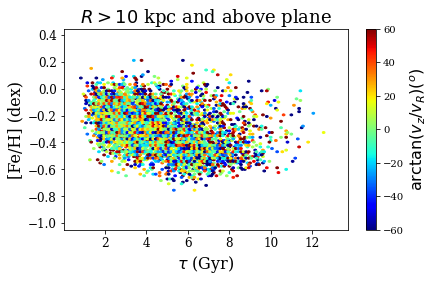

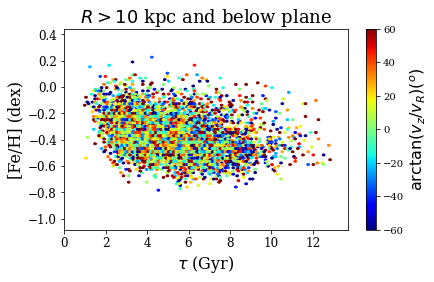

In [26]:
velVectorAngle = (np.arctan2(vz,vR))/np.pi * 180.
VMIN = -60.
VMAX = 60.

# 2D velocity vector angle map in [Fe/H]-age
plt.rc('font',family='serif')  
fig1 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age,feh,C=velVectorAngle,
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=100,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\arctan(v_z/v_R) (^o)$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_lowalpha.eps"
fig1.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_lowalpha.png"
fig1.savefig(plotfile,format='png')

# 2D velocity vector angle map in [Fe/H]-age for outer disc
index = R>10
plt.rc('font',family='serif')  
fig2 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=velVectorAngle[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=100,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\arctan(v_z/v_R) (^o)$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_lowalpha.eps"
fig2.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_lowalpha.png"
fig2.savefig(plotfile,format='png')

# 2D velocity vector angle map in [Fe/H]-age for outer disc in the plane
index = (R>10) & (z<0.6) & (z>-0.6)
plt.rc('font',family='serif')  
fig3 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=velVectorAngle[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=100,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and in-plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\arctan(v_z/v_R) (^o)$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_plane_lowalpha.eps"
fig3.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_plane_lowalpha.png"
fig3.savefig(plotfile,format='png')

# 2D velocity vector angle map in [Fe/H]-age for outer disc above plane
index = (R>10) & (z>0.6)
plt.rc('font',family='serif')  
fig4 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=velVectorAngle[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=100,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and above plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\arctan(v_z/v_R) (^o)$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_aboveplane_lowalpha.eps"
fig4.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_aboveplane_lowalpha.png"
fig4.savefig(plotfile,format='png')

# 2D velocity vector angle map in [Fe/H]-age for outer disc below plane
index = (R>10) & (z<-0.6)
plt.rc('font',family='serif')  
fig5 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(age[index],feh[index],C=velVectorAngle[index],
                     reduce_C_function=np.mean,cmap="jet",vmin=VMIN,vmax=VMAX,
                     gridsize=100,mincnt=1)
plt.xlabel(r"$\tau$ (Gyr)",fontsize=16)
plt.ylabel(r"[Fe/H] (dex)",fontsize=16)
plt.title(r"$R>10$ kpc and below plane",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\arctan(v_z/v_R) (^o)$",size=16)
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_belowplane_lowalpha.eps"
fig5.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_agefeh_velvectorangle_Rmin10_belowplane_lowalpha.png"
fig5.savefig(plotfile,format='png')

## Plot 2-D $\tau$-$R$ maps

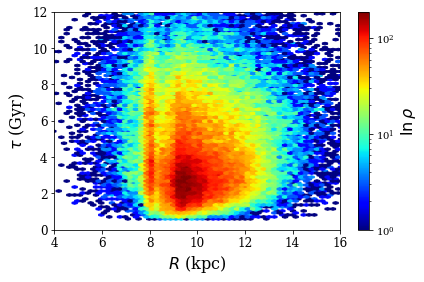

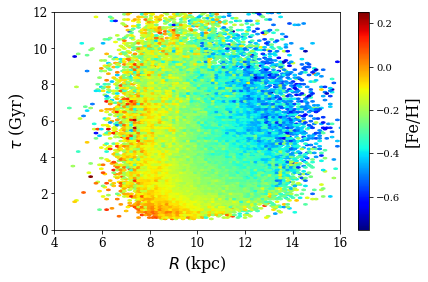

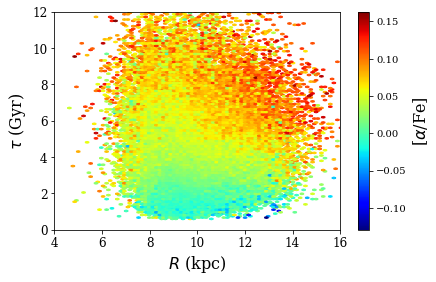

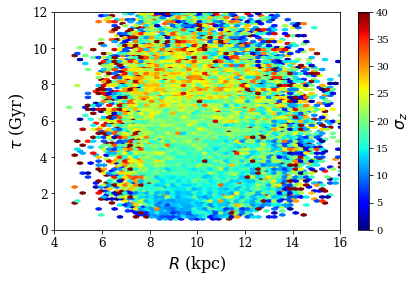

In [27]:
# 2D density map in age-R
plt.rc('font',family='serif')  
fig6 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R,age,bins="log",cmap="jet",gridsize=100,mincnt=1)
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$\tau$ (Gyr)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.,12.])
plt.xlim([4.,16.])
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\ln \rho$",size=16)
plotfile = "../plots/data/2Dhistogram_Rage_rho_lowalpha.eps"
fig6.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rage_rho_lowalpha.png"
fig6.savefig(plotfile,format='png')

# 2D feh map in age-R
plt.rc('font',family='serif')  
fig6 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R,age,C=feh,reduce_C_function=np.mean,
                     cmap="jet",gridsize=150,mincnt=1)
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$\tau$ (Gyr)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.,12.])
plt.xlim([4.,16.])
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label="[Fe/H]",size=16)
plotfile = "../plots/data/2Dhistogram_Rage_feh_lowalpha.eps"
fig6.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rage_feh_lowalpha.png"
fig6.savefig(plotfile,format='png')

# 2D afe map in age-R
plt.rc('font',family='serif')  
fig6 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R,age,C=afe,reduce_C_function=np.mean,
                     cmap="jet",gridsize=150,mincnt=1)
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$\tau$ (Gyr)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.,12.])
plt.xlim([4.,16.])
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"[$\alpha$/Fe]",size=16)
plotfile = "../plots/data/2Dhistogram_Rage_afe_lowalpha.eps"
fig6.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rage_afe_lowalpha.png"
fig6.savefig(plotfile,format='png')

# 2D sigmaz map in age-R
plt.rc('font',family='serif')  
fig6 = plt.figure(figsize=(6,4))   
dispmap = plt.hexbin(R,age,C=vz,reduce_C_function=np.std,vmin=0.,vmax=40.,
                     cmap="jet",gridsize=100,mincnt=1)
plt.xlabel(r"$R$ (kpc)",fontsize=16)
plt.ylabel(r"$\tau$ (Gyr)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.,12.])
plt.xlim([4.,16.])
plt.tight_layout(pad=1)
plt.colorbar(dispmap).set_label(label=r"$\sigma_z$",size=16)
plotfile = "../plots/data/2Dhistogram_Rage_sigz_lowalpha.eps"
fig6.savefig(plotfile,format='eps')
plotfile = "../plots/data/2Dhistogram_Rage_sigz_lowalpha.png"
fig6.savefig(plotfile,format='png')
